# TSNN examples

## Summary

- In narrow format, both lin reg and fully connected manage to capture a linear effect between features and target. A linear regression will always be better in this case since this is constrained to be exactly the function of the ground truth


In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import importlib
import sys
sys.path.append('/Users/cyrilgarcia/notebooks/tsnn/')

import tsnn

from tsnn.generators import generators
from tsnn.benchmarks import benchmark_comparison, ml_benchmarks, torch_benchmarks
from tsnn import utils

plt.style.use('ggplot')

In [2]:
z = generators.Generator(1000, 100, 10)

In [3]:
%%time
X, y = z.generate_dataset()

CPU times: user 385 ms, sys: 34.7 ms, total: 420 ms
Wall time: 58.9 ms


In [4]:
train, test = utils.np_to_torch(X, y)

### Simple benchmarks

In [5]:
# lasso benchmark
lasso = ml_benchmarks.LassoBenchmark()
lasso.fit(train)

In [6]:
lasso.score(train)

np.float64(0.04269901999523229)

In [7]:
# any custom benchmark
from sklearn.linear_model import LinearRegression
lr = ml_benchmarks.CustomBenchmark(LinearRegression())
lr.fit(train)

In [8]:
comp = benchmark_comparison.Comparator(models=[lasso, lr], model_names=['lasso', 'lr'])

In [9]:
comp.correl(train, z.y_pred_optimal[train.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr
y_true,1.000000,0.039390,0.042699,0.042699
y_optimal,0.039390,1.000000,0.922679,0.922502
lasso,0.042699,0.922679,1.000000,0.999999
lr,0.042699,0.922502,0.999999,1.000000


In [10]:
## BUG HERE

In [11]:
comp.correl(test, z.y_pred_optimal[train.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr
y_true,1.000000,0.004494,0.041334,0.041327
y_optimal,0.004494,1.000000,-0.009340,-0.009350
lasso,0.041334,-0.009340,1.000000,0.999999
lr,0.041327,-0.009350,0.999999,1.000000


## Torch benchmarks

### Narrow matrix (equivalent to linear regression setup)

In [12]:
train, test = utils.np_to_torch(X, y, narrow=True)

In [13]:
from torch import nn
device = 'mps'

class NeuralNetwork(nn.Module):
    def __init__(self, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_f, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )
        
    def forward(self, x):
        pred = self.linear_relu_stack(x)
        return pred

In [14]:
m = NeuralNetwork(n_f=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-2)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [15]:
full_nn.fit(train, test, epochs=20)

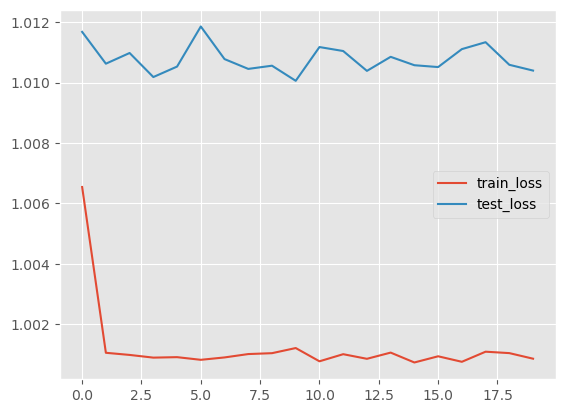

In [16]:
pd.concat([pd.Series(full_nn.train_loss).rename('train_loss'), pd.Series(full_nn.test_loss).rename('test_loss')], axis=1).plot();

In [17]:
comp = benchmark_comparison.Comparator(models=[full_nn], model_names=['nn'])

In [18]:
opt_dim = z.y_pred_optimal.shape
comp.correl(train, z.y_pred_optimal.flatten()[train.dataset.indices])

,y_true,y_optimal,nn
y_true,1.000000,0.039390,0.043698
y_optimal,0.039390,1.000000,0.846414
nn,0.043698,0.846414,1.000000


In [19]:
comp.correl(test, z.y_pred_optimal.flatten()[test.dataset.indices])

,y_true,y_optimal,nn
y_true,1.000000,0.045977,0.037988
y_optimal,0.045977,1.000000,0.844104
nn,0.037988,0.844104,1.000000


### Fully connected

In [54]:
train, test = utils.np_to_torch(X, y)

In [55]:
train.batch_size, test.batch_size

(64, 64)

In [63]:
from torch import nn
device = 'mps'

class NeuralNetwork(nn.Module):
    def __init__(self, n_ts, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_ts*n_f, 512),
            nn.ReLU(),
            # nn.Linear(512, 512),
            # nn.ReLU(),
            nn.Linear(512, n_ts),
        )
        
        self.linear_relu_stack = nn.Sequential(nn.Linear(n_ts*n_f, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_ts)
                                              )

    def forward(self, x):
        x = self.flatten(x)
        pred = self.linear_relu_stack(x)
        return pred

In [64]:
m = NeuralNetwork(n_ts=100, n_f=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-2)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [65]:
full_nn.fit(train, test, epochs=20)

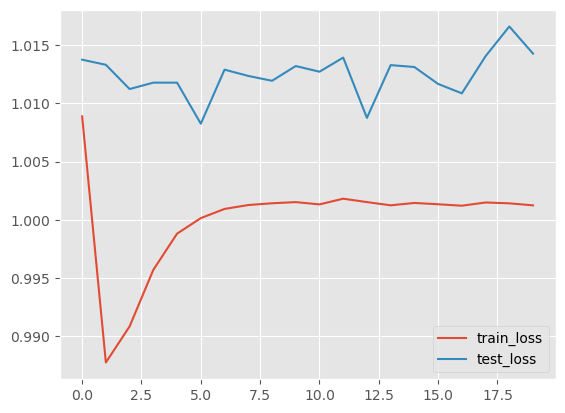

In [66]:
pd.concat([pd.Series(full_nn.train_loss).rename('train_loss'), pd.Series(full_nn.test_loss).rename('test_loss')], axis=1).plot();

In [67]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, full_nn], model_names=['lasso', 'lr', 'nn'])

In [68]:
comp.correl(train, z.y_pred_optimal[train.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr,nn
y_true,1.000000,0.039390,0.042699,0.042699,0.032152
y_optimal,0.039390,1.000000,0.922679,0.922502,-0.000907
lasso,0.042699,0.922679,1.000000,0.999999,-0.001600
lr,0.042699,0.922502,0.999999,1.000000,-0.001604
nn,0.032152,-0.000907,-0.001600,-0.001604,1.000000


In [69]:
comp.correl(test, z.y_pred_optimal[test.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr,nn
y_true,1.000000,0.045977,0.041334,0.041327,-0.002212
y_optimal,0.045977,1.000000,0.921502,0.921325,-0.005891
lasso,0.041334,0.921502,1.000000,0.999999,-0.002693
lr,0.041327,0.921325,0.999999,1.000000,-0.002698
nn,-0.002212,-0.005891,-0.002693,-0.002698,1.000000


### LSTM model with 10 timestamps

In [33]:
train, test = utils.np_to_torch(X, y, n_rolling=10)

In [34]:
from torch import nn
device = 'mps'

class LSTMModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, hidden_dim=128):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_ts*n_f, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, n_ts)
    
    def forward(self, x):
        # warning: lstm dimension needs to be flattened:
        # x: (batch, T=10, n_ts*n_f)
        _, (h, _) = self.encoder(x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]))
        out = self.decoder(h[-1]) 
        return out

In [35]:
m = LSTMModel(n_ts=100, n_f=10, n_rolling=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_lstm = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [36]:
model_lstm.fit(train, test=test, epochs=10)

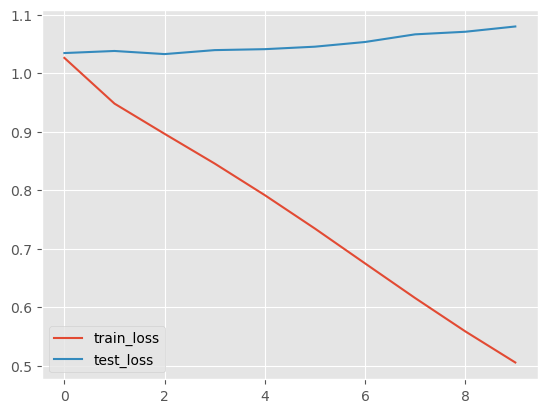

In [37]:
pd.concat([pd.Series(model_lstm.train_loss).rename('train_loss'), pd.Series(model_lstm.test_loss).rename('test_loss')], axis=1).plot();

In [38]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm], model_names=['lasso', 'lr', 'lstm'])

In [39]:
comp.correl(train, z.y_pred_optimal[train.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr,lstm
y_true,1.000000,0.039390,0.042699,0.042699,0.782612
y_optimal,0.039390,1.000000,0.922679,0.922502,0.034654
lasso,0.042699,0.922679,1.000000,0.999999,0.037060
lr,0.042699,0.922502,0.999999,1.000000,0.037057
lstm,0.782612,0.034654,0.037060,0.037057,1.000000


In [40]:
comp.correl(test, z.y_pred_optimal[test.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr,lstm
y_true,1.000000,0.045977,0.041334,0.041327,0.002266
y_optimal,0.045977,1.000000,0.921502,0.921325,0.014355
lasso,0.041334,0.921502,1.000000,0.999999,0.013488
lr,0.041327,0.921325,0.999999,1.000000,0.013491
lstm,0.002266,0.014355,0.013488,0.013491,1.000000


### Transformer

In [41]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.5):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        encoded = self.encoder(x, src_key_padding_mask=mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [42]:
m = TransformerEncoderModel(100, 10, 10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [43]:
model_torch.fit(train, test=test, epochs=100)

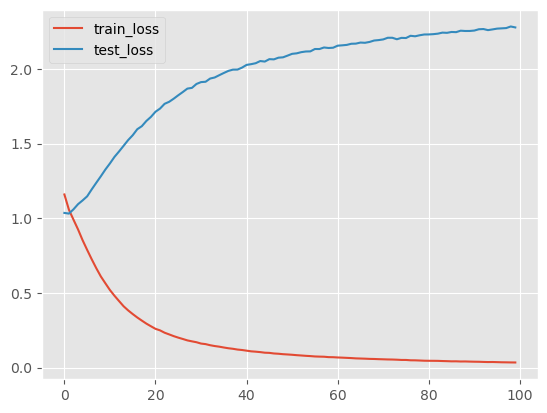

In [44]:
pd.concat([pd.Series(model_torch.train_loss).rename('train_loss'), pd.Series(model_torch.test_loss).rename('test_loss')], axis=1).plot();

In [45]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [46]:
comp.correl(train, z.y_pred_optimal[train.dataset.indices].flatten()).round(3)

,y_true,y_optimal,lasso,lr,lstm,transformer
y_true,1.000,0.039,0.043,0.043,0.783,0.982
y_optimal,0.039,1.000,0.923,0.923,0.035,0.039
lasso,0.043,0.923,1.000,1.000,0.037,0.042
lr,0.043,0.923,1.000,1.000,0.037,0.042
lstm,0.783,0.035,0.037,0.037,1.000,0.775
transformer,0.982,0.039,0.042,0.042,0.775,1.000


In [47]:
comp.correl(test, z.y_pred_optimal[test.dataset.indices].flatten()).round(3)

,y_true,y_optimal,lasso,lr,lstm,transformer
y_true,1.000,0.046,0.041,0.041,0.002,0.014
y_optimal,0.046,1.000,0.922,0.921,0.014,0.017
lasso,0.041,0.922,1.000,1.000,0.013,0.021
lr,0.041,0.921,1.000,1.000,0.013,0.021
lstm,0.002,0.014,0.013,0.013,1.000,0.127
transformer,0.014,0.017,0.021,0.021,0.127,1.000
